In [156]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import torch
from transformers import AutoTokenizer, AutoModel

tqdm.pandas()

device = torch.device('cuda')

In [157]:
data = pd.read_excel('../Выгрузка_Классификатор_для передачи_1 заход.xlsx')

In [158]:
data

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки
0,9886272994,Мужской,28.05.1980,Центральный ФО,Московская,Россия,"ООО ""РЖД-Технологии""",Директор по стратегии,Кандидат наук,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN
1,8010695393,Мужской,09.10.1977,Центральный ФО,Орловская,Россия,ПАО МегаФон,начальник,Два и более высших образований,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN
2,4851605917,Мужской,08.12.1991,Уральский ФО,Свердловская,Россия,"ООО ""Генная Хирургия""",Исполнительный директор,Два и более высших образований,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN
3,4093896163,Мужской,18.07.1973,Северо-Западный ФО,Санкт-Петербург,Россия,"ООО ""Спецстроймонтаж""; ООО ""СЕРВИС ТИМ""; ООО ""...",Исполнительный директор; Генеральный директор;...,Два и более высших образований,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN
4,7512508692,Мужской,19.01.1980,Центральный ФО,Москва,Россия,ПАО «Вымпелком»,Директор по стратегии и долгосрочному планиров...,"Высшее, специалитет, магистратура",4,Руководитель управления корпоративной функции ...,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75234,5143980152,Мужской,03.09.1967,NaN,NaN,Эстония,ООО Стивтранс,Член правления,Два и более высших образований,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN
75235,7339537870,Мужской,17.03.1995,Центральный ФО,Белгородская,Россия,NaN,NaN,Два и более высших образований,12,Не работаю,Не работаю,Не работаю,NaN,NaN
75236,3799741744,Мужской,12.08.1995,NaN,NaN,Таджикистан,РУДН,Врач-ординатор РУДН,Два и более высших образований,12,Не работаю,Не работаю,Полный аналог,NaN,NaN
75237,9663315939,Мужской,11.01.1982,NaN,NaN,Казахстан,Группа инженерных компаний Интерконд,Управляющий партнер,"Высшее, специалитет, магистратура",5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN


In [159]:
data['Дата рождения'] = pd.to_datetime(data['Дата рождения'], format="%d.%m.%Y")
data['age'] = pd.Timestamp('now').year - data['Дата рождения'].dt.year



LE = LabelEncoder()
# data['label'] = LE.fit_transform(data['Сфера деятельности по Классификатору ФОИР'])
data['label'] = LE.fit_transform(data['Карьерная ступень по Классификатору ФОИР'])

text_cols  = ['Место работы', 'Наименование текущей должности']
cat_cols = ['age', 'Пол', 'Регион', 'Страна проживания', 'Уровень образования']
data[text_cols] = data[text_cols].fillna('Пропущенное значение')

In [160]:
df = data[data['Ручная проверка карьерной ступени'].notna()]
df_train, df_val, y_train, y_val= train_test_split(df[cat_cols + text_cols], df['label'], random_state=42)

In [161]:
df = data.copy()

df_val = df[df['Ручная проверка карьерной ступени'].notna()][cat_cols + text_cols]
y_val = df[df['Ручная проверка карьерной ступени'].notna()]['label']

df_train = df[df['Ручная проверка карьерной ступени'].isna()][cat_cols + text_cols]
y_train = df[df['Ручная проверка карьерной ступени'].isna()]['label']

In [162]:
# df = df.fillna('NaN')

In [163]:
df.nunique()

Номер                                                   75239
Пол                                                         2
Дата рождения                                           12930
Федеральный округ                                           8
Регион                                                     86
Страна проживания                                         131
Место работы                                            52557
Наименование текущей должности                          33352
Уровень образования                                        10
Карьерная ступень по Классификатору ФОИР                   12
Наименование выбранной типовой должности                  169
Сфера деятельности по Классификатору ФОИР                   8
Соответствует ли выбранная типовая текущей должности        5
Ручная проверка карьерной ступени                          11
Разница по итогам проверки                                 12
age                                                        44
label   

In [164]:
df['Наименование выбранной типовой должности'].value_counts()[:20].sum()

52826

Посмотрим распределение таргета

<Axes: >

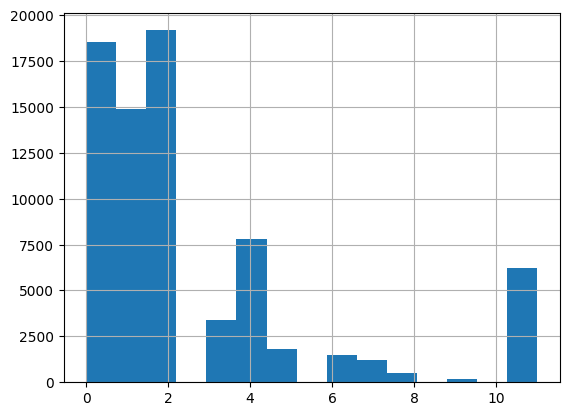

In [165]:
df['label'].hist(bins=15)

In [166]:
df['Ручная проверка карьерной ступени']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
75234   NaN
75235   NaN
75236   NaN
75237   NaN
75238   NaN
Name: Ручная проверка карьерной ступени, Length: 75239, dtype: float64

## Создадим категориальные фичи 
(Возраст, Пол, Регион, Страна проживания, Уровень образования, Соответствует ли выбранная типовая текущей должности)

In [167]:
cat_transformer = ColumnTransformer([('encoder', OrdinalEncoder(encoded_missing_value=-1), cat_cols)], remainder='passthrough', verbose_feature_names_out=True)
cat_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OrdinalEncoder(encoded_missing_value=-1),
                                 ['age', 'Пол', 'Регион', 'Страна проживания',
                                  'Уровень образования'])])

In [168]:
cat_transformer.fit_transform(df)

,encoder__age,encoder__Пол,encoder__Регион,encoder__Страна проживания,encoder__Уровень образования,remainder__Номер,remainder__Дата рождения,remainder__Федеральный округ,remainder__Место работы,remainder__Наименование текущей должности,remainder__Карьерная ступень по Классификатору ФОИР,remainder__Наименование выбранной типовой должности,remainder__Сфера деятельности по Классификатору ФОИР,remainder__Соответствует ли выбранная типовая текущей должности,remainder__Ручная проверка карьерной ступени,remainder__Разница по итогам проверки,remainder__label
0,23.0,1.0,43.0,91.0,5.0,9886272994,1980-05-28,Центральный ФО,"ООО ""РЖД-Технологии""",Директор по стратегии,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN,0
1,26.0,1.0,51.0,91.0,3.0,8010695393,1977-10-09,Центральный ФО,ПАО МегаФон,начальник,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,2
2,12.0,1.0,63.0,91.0,3.0,4851605917,1991-12-08,Уральский ФО,"ООО ""Генная Хирургия""",Исполнительный директор,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,4
3,30.0,1.0,59.0,91.0,3.0,4093896163,1973-07-18,Северо-Западный ФО,"ООО ""Спецстроймонтаж""; ООО ""СЕРВИС ТИМ""; ООО ""...",Исполнительный директор; Генеральный директор;...,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,1
4,23.0,1.0,42.0,91.0,2.0,7512508692,1980-01-19,Центральный ФО,ПАО «Вымпелком»,Директор по стратегии и долгосрочному планиров...,4,Руководитель управления корпоративной функции ...,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75234,36.0,1.0,-1.0,126.0,3.0,5143980152,1967-09-03,NaN,ООО Стивтранс,Член правления,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,1
75235,8.0,1.0,8.0,91.0,3.0,7339537870,1995-03-17,Центральный ФО,Пропущенное значение,Пропущенное значение,12,Не работаю,Не работаю,Не работаю,NaN,NaN,11
75236,8.0,1.0,-1.0,104.0,3.0,3799741744,1995-08-12,NaN,РУДН,Врач-ординатор РУДН,12,Не работаю,Не работаю,Полный аналог,NaN,NaN,11
75237,21.0,1.0,-1.0,51.0,2.0,9663315939,1982-01-11,NaN,Группа инженерных компаний Интерконд,Управляющий партнер,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,4


## Для текстовых полей низкой уникальности создадим фичи на основе эмбедингов
(Место работы, Наименование текущей должности, Наименование выбранной типовой должности, )

In [169]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model = AutoModel.from_pretrained("ai-forever/ruBert-base").to(device)

In [170]:
df_train.shape, y_train.shape, df_val.shape, y_val.shape

((74948, 7), (74948,), (291, 7), (291,))

In [171]:
from sklearn.base import BaseEstimator, TransformerMixin


class BERTEmbExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer=None, model=None, columns=None, batch_size=128):
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
            
        if model:
            self.model = model
        else:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model = AutoModel.from_pretrained("ai-forever/ruBert-base").to(device)
            
        self.columns = columns
        self.batch_size = batch_size
        
    def bert_extract(self, X, col):
        out_emb = []
        total_samples = len(X)

        for start in tqdm(range(0, total_samples, self.batch_size)):
            end = min(start + self.batch_size, total_samples)
            
            batch_X = X[col].values[start:end]  # Extract a batch of data
            tokenized = tokenizer(batch_X.tolist(), padding = True, truncation = True, return_tensors="pt")
            column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}

            hidden_state = model(**column_tokens) #dim : [batch_size(nr_sentences), tokens, emb_dim]
            emb = hidden_state.last_hidden_state[:,0,:].to("cpu")
            del hidden_state
            
            df_emb = pd.DataFrame(emb, columns=[f'{col}_{i}' for i in range(emb.shape[1])])
            out_emb.append(df_emb)
            
        return pd.concat(out_emb)
    
    def fit(self, X, y=None):
        if not self.columns:
            self.columns = X.columns
        
        self.column_df_emb = {}
        self.column_pca = {}
        with torch.no_grad():
            for col in self.columns:
                df_emb = self.bert_extract(X, col)
                
                pca = PCA(0.99)
                pca.set_output(transform='pandas')
                
                df_emb = pca.fit_transform(df_emb)

                self.column_pca[col] = pca
            
        return self

    def transform(self, X, y=None):
        out = []
        with torch.no_grad():
            for col in self.columns:
                df_emb = self.bert_extract(X, col)
                df_emb = self.column_pca[col].transform(df_emb)
                df_emb.columns = [f'{col}_{pca_col}' for pca_col in df_emb.columns]
                out.append(df_emb)
        
        return pd.concat(out, axis=1)

In [172]:
be = BERTEmbExtractor()

In [173]:
%%time
be.fit_transform(df_train[text_cols])

  0%|          | 0/586 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/586 [00:00<?, ?it/s]/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/586 [00:00<?, ?it/s]/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use so

CPU times: user 4min 14s, sys: 38.6 s, total: 4min 53s
Wall time: 3min


,Место работы_pca0,Место работы_pca1,Место работы_pca2,Место работы_pca3,Место работы_pca4,Место работы_pca5,Место работы_pca6,Место работы_pca7,Место работы_pca8,Место работы_pca9,...,Наименование текущей должности_pca462,Наименование текущей должности_pca463,Наименование текущей должности_pca464,Наименование текущей должности_pca465,Наименование текущей должности_pca466,Наименование текущей должности_pca467,Наименование текущей должности_pca468,Наименование текущей должности_pca469,Наименование текущей должности_pca470,Наименование текущей должности_pca471
0,2.097736,-3.141485,1.527721,1.018539,1.976734,-1.089206,0.934090,-2.057390,3.104365,0.511841,...,2.565220e-03,-0.085155,-0.032947,0.086071,-0.076292,-0.124164,-0.067223,0.092124,0.023502,-0.080124
1,0.222175,-0.859347,-3.323832,-3.663850,0.180166,-0.509260,-0.044608,0.438273,-0.642275,1.562712,...,3.187087e-02,0.036001,-0.024376,0.026279,-0.014563,0.082933,-0.019822,-0.033334,0.027458,0.073622
2,0.781419,-2.411698,-2.199100,3.189834,1.698199,0.588629,-1.758165,0.853915,1.144396,-0.115299,...,1.051459e-02,-0.018537,-0.001714,0.004085,0.000992,-0.000766,0.005405,-0.006325,-0.015052,0.016595
3,1.070110,-1.512653,0.373576,2.835340,-2.106735,1.078496,-3.034760,0.889164,-0.656621,-3.324300,...,-1.063966e-01,0.072076,0.148913,-0.013042,0.091138,-0.090596,0.018906,0.033153,-0.078529,-0.217869
4,0.241400,-1.658811,-2.121963,1.843289,-1.701971,-0.365184,-0.229579,0.467023,-0.753979,1.357713,...,2.882788e-02,-0.175820,-0.072203,0.139563,0.191949,-0.031141,-0.091465,-0.027943,-0.094560,0.031220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,1.222379,-0.497969,-3.743077,-2.996310,0.689848,0.671857,-0.670229,1.664109,1.307766,0.250299,...,6.795681e-02,0.064866,-0.114190,0.006871,-0.006297,-0.042330,-0.019813,-0.037809,-0.019691,0.017120
64,-7.782558,1.794498,0.291758,0.416464,0.043214,-0.294673,0.109744,-0.168612,0.203005,0.086867,...,-4.619360e-07,0.000257,-0.000028,-0.000026,0.000088,0.000443,-0.000074,0.000054,-0.000552,-0.000056
65,0.131947,-0.368252,-0.530883,-1.380032,-2.044461,1.402663,0.318511,0.035127,-2.219517,-0.107684,...,1.362002e-01,0.099363,-0.086855,0.096653,0.213400,0.018479,-0.073323,0.119225,0.065617,0.003810
66,2.448724,-0.853921,1.777579,-1.934753,1.179254,0.415871,-2.124197,-0.894599,-0.292198,-0.652601,...,2.783228e-02,0.041412,0.042727,-0.041857,0.054148,-0.027433,0.075329,-0.050741,0.005990,0.025225


## Обучим пайплайн

In [174]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer

In [175]:
data_transformer =  ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('text_encoder', BERTEmbExtractor(tokenizer, model, batch_size=32), text_cols)
    ], remainder='drop', verbose_feature_names_out=True)

data_prepare = Pipeline([
    ('preproc', data_transformer),
    ('imputer', SimpleImputer()),
    ])

pipe = Pipeline([
    ('model', ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5))
    ])

In [176]:
%%time

X_train = data_prepare.fit_transform(df_train)
X_val = data_prepare.transform(df_val)

  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
 31%|███       | 719/2343 [00:12<00:29, 55.74it/s]

  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_45921/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens

CPU times: user 6min 55s, sys: 11min 12s, total: 18min 8s
Wall time: 3min 34s


In [177]:
%%time 

pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

CPU times: user 55.1 s, sys: 779 ms, total: 55.9 s
Wall time: 14.1 s


0.16151202749140894

## Cross Val

In [178]:
X_train.shape

(74948, 1046)

In [179]:
%%time
cross_val_score(pipe, X_train, y_train, n_jobs=1)

CPU times: user 3min 25s, sys: 29.3 ms, total: 3min 25s
Wall time: 53.1 s


array([0.34629753, 0.36837892, 0.35977318, 0.35506038, 0.36239909])

Попробуем регуляризацию и прунинг

In [180]:
from sklearn.tree import DecisionTreeClassifier

In [190]:
%%time
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


In [ ]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

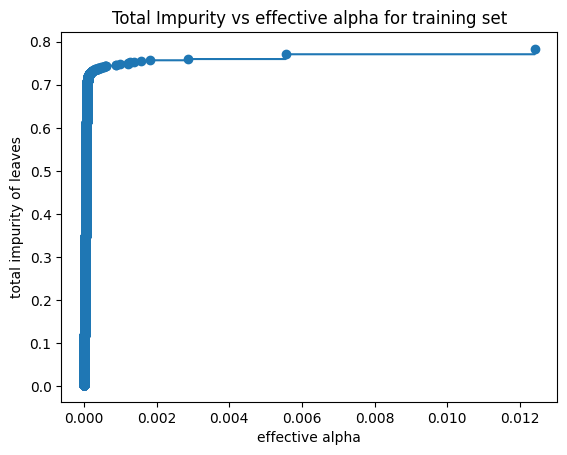

In [191]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [192]:
impurities[abs(impurities -  0.425) < 0.0001]

array([0.42500079])

In [197]:
impurities[-15:]

array([0.74434007, 0.74522757, 0.74611548, 0.74711511, 0.74833562,
       0.7495586 , 0.75081533, 0.75209938, 0.75348668, 0.75506212,
       0.75689624, 0.75976539, 0.77087404, 0.78328016, 0.81358954])

In [214]:
ccp_alphas[abs(impurities - 0.705) < 0.0001]

array([9.68656472e-05])

In [215]:
ccp_alphas = [ccp_alphas[abs(impurities - thr) < 0.0001].min() for thr in [0.02, 0.1, 0.2, 0.3, 0.4, 0.51, 0.6, 0.705]] + ccp_alphas[-15:].tolist()

# ccp_alphas = [ccp_alphas[abs(impurities - thr) < 0.0001].min() for thr in [0.01, 0.1, 0.2, 0.3, 0.4, 0.425]] + ccp_alphas[-14:].tolist()


In [216]:
ccp_alphas

[1.207186188773423e-05,
 1.75546548875194e-05,
 2.4906157157851665e-05,
 3.77593748061033e-05,
 5.187190447395574e-05,
 6.328498430848816e-05,
 7.254957579156123e-05,
 9.686564719934686e-05,
 0.0006128459471302083,
 0.0008875053257529492,
 0.0008879126389170211,
 0.0009996247960981641,
 0.001220511140405306,
 0.0012229794052464743,
 0.0012567262454916406,
 0.0012840509943528276,
 0.001387306949584069,
 0.0015754317808848728,
 0.001834125607684256,
 0.0028691501485132442,
 0.005554323878597445,
 0.012406120899525919,
 0.030309375432683305]

In [217]:
clfs = []
for ccp_alpha in tqdm(ccp_alphas):
    clf = ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5, random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

100%|██████████| 23/23 [23:21<00:00, 60.94s/it]


Карьерная ступень по Классификатору ФОИР

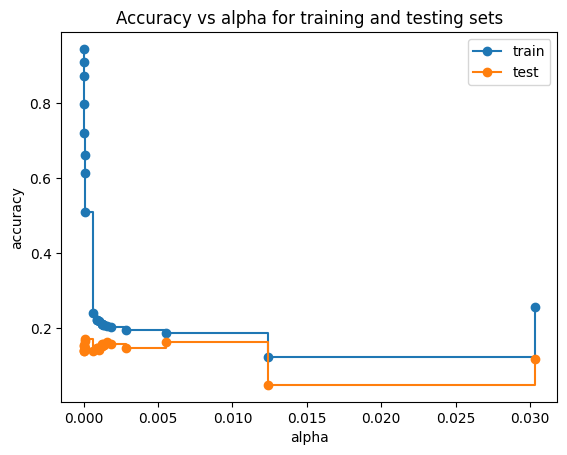

In [218]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [227]:
test_scores[7]

0.1718213058419244

In [228]:
clfs[7]

ExtraTreesClassifier(bootstrap=True, ccp_alpha=9.686564719934686e-05,
                     class_weight='balanced_subsample', n_jobs=5,
                     oob_score=True, random_state=0)

ccp_alpha=9.686564719934686e-05

Сфера деятельности по Классификатору ФОИР

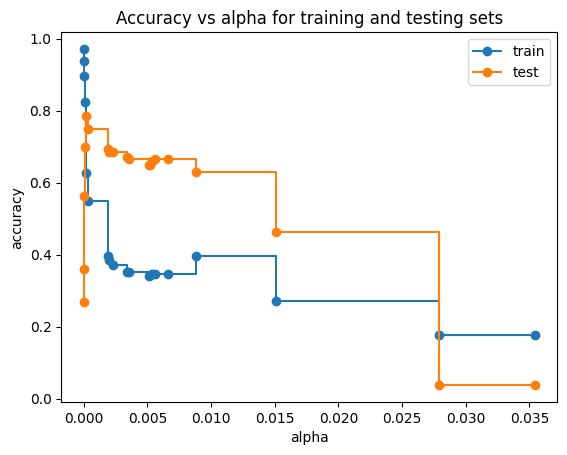

In [135]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [140]:
test_scores[4]

0.7835051546391752

In [141]:
clfs[4]

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.00016355852637635468,
                     class_weight='balanced_subsample', n_jobs=5,
                     oob_score=True, random_state=0)

Лучший коэф для прунинга 0.00016355852637635468

In [229]:
pipe = Pipeline([
    ('model', ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5, ccp_alpha=9.686564719934686e-05))
    ])

In [230]:
cross_val_score(pipe, X_train, y_train, n_jobs=1)

array([0.32488326, 0.32741828, 0.33382255, 0.32830743, 0.33070919])

In [231]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('model',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=9.686564719934686e-05,
                                      class_weight='balanced_subsample',
                                      n_jobs=5, oob_score=True))])

In [232]:
y_pred = pipe.predict(X_val)

## Метрики для - Сфера деятельности по Классификатору ФОИР

In [145]:
print(classification_report(y_val, y_pred,))

              precision    recall  f1-score   support

           0       0.43      0.75      0.55         8
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.40      0.29      0.33         7
           4       0.90      0.90      0.90        39
           5       0.31      0.33      0.32        12
           6       0.87      0.82      0.85        97
           7       0.93      0.84      0.89       128

    accuracy                           0.81       291
   macro avg       0.48      0.49      0.48       291
weighted avg       0.85      0.81      0.83       291



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [146]:
LE.classes_

array(['Государственные корпорации и Институты развития',
       'Коммерческие компании, государственные/муниципальные предприятия',
       'Не работаю',
       'Общественные/общественно-политические организации и НКО ',
       'Органы местного самоуправления (ОМСУ)',
       'Подведомственные органам власти (государственные/муниципальные) организации',
       'Региональные органы государственной власти, в т.ч. гражданская служба субъектов РФ',
       'Федеральные государственные органы, в т.ч. федеральная государственная служба'],
      dtype=object)

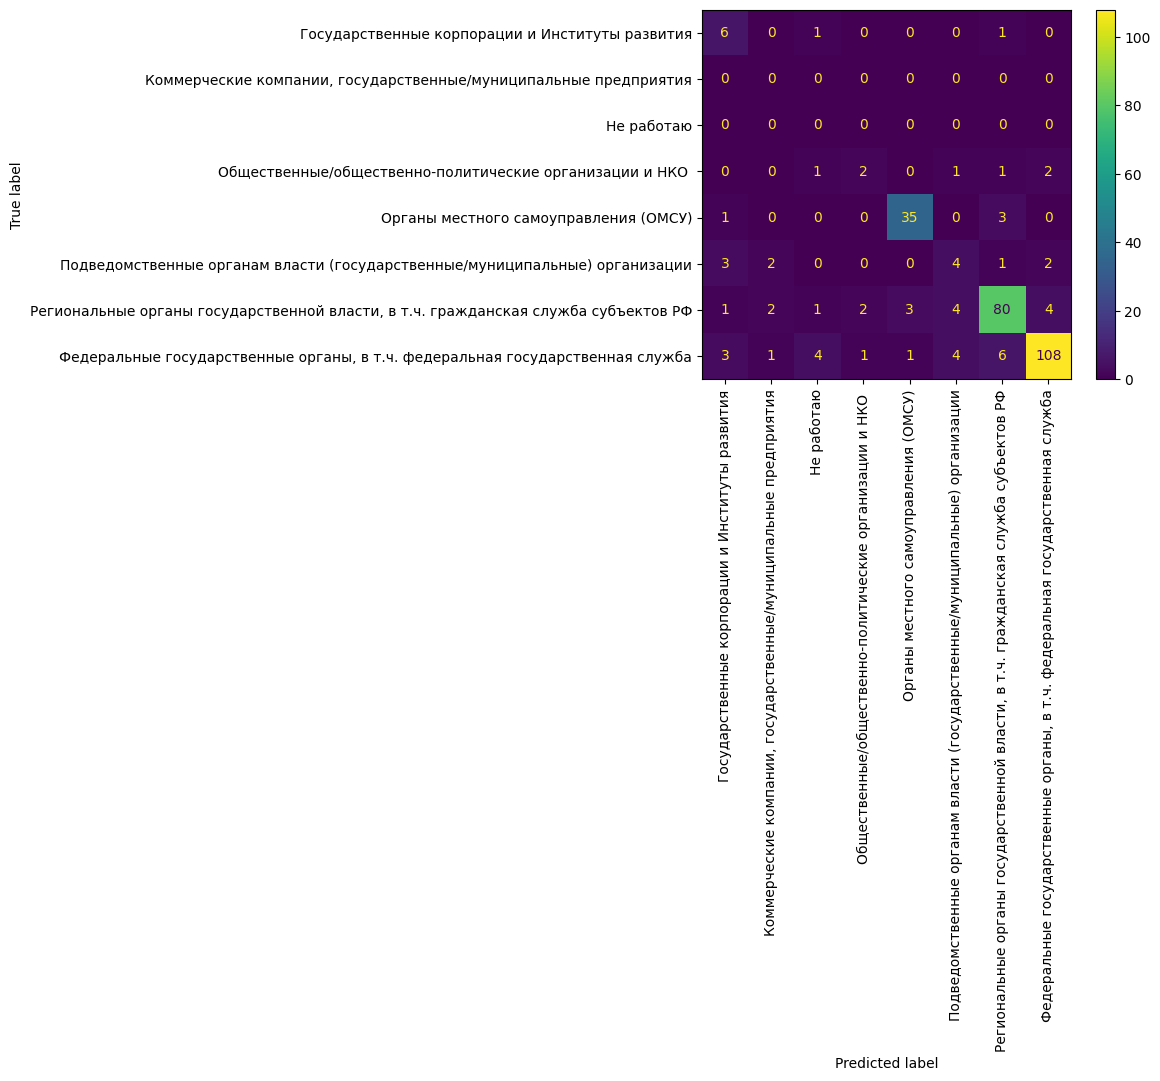

In [147]:
ConfusionMatrixDisplay.from_estimator(
    pipe, X_val, y_val, display_labels=LE.classes_[:], xticks_rotation="vertical"
)

## Метрики для - Карьерная ступень по Классификатору ФОИР

In [233]:
print(classification_report(y_val, y_pred,))

              precision    recall  f1-score   support

           0       0.29      0.12      0.17        16
           1       0.17      0.02      0.04        46
           2       0.21      0.35      0.26        34
           3       0.19      0.89      0.31        38
           4       0.00      0.00      0.00        38
           5       0.12      0.07      0.09        15
           6       0.14      0.11      0.12         9
           7       1.00      0.02      0.03        57
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         0

    accuracy                           0.18       291
   macro avg       0.18      0.13      0.09       291
weighted avg       0.30      0.18      0.10       291



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [234]:
LE.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

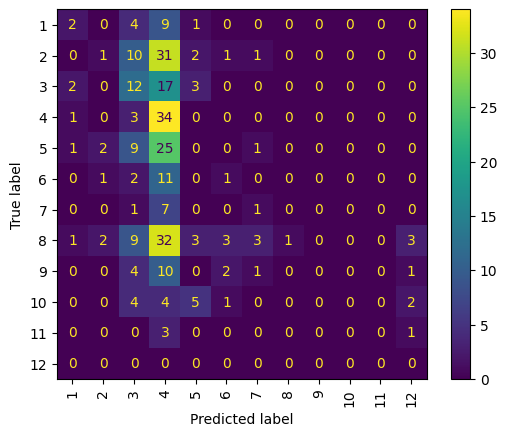

In [236]:
ConfusionMatrixDisplay.from_estimator(
    pipe, X_val, y_val, display_labels=LE.classes_[:], xticks_rotation="vertical"
)